In [1]:
import pandas as pd
#read communications.csv
communications = pd.read_csv('communications.csv')
communications['Text']

0      Minutes of the Federal Open Market Committee\n...
1      Recent indicators suggest that economic activi...
2      Recent indicators suggest that economic activi...
3      Minutes of the Federal Open Market Committee\n...
4      Recent indicators suggest that economic activi...
                             ...                        
435    The Federal Open Market Committee voted today ...
436    Minutes of the Federal Open Market Committee\n...
437    The Federal Open Market Committee voted today ...
438    Minutes of the Federal Open Market Committee\n...
439    The Federal Open Market Committee voted today ...
Name: Text, Length: 440, dtype: object

In [141]:
#check the mean number of characters per type (minute/statement)
communications.groupby('Type')['Text'].apply(lambda x: x.str.len().mean())

Type
Minute       48114.781659
Statement     2667.734597
Name: Text, dtype: float64

In [2]:
import os
from mistralai import Mistral
from skfin.datasets import load_fomc_statements
from tqdm import tqdm
import time


with open("../mistral_key.txt", "r") as f:
    api_key = f.read().strip()
def analyze_monetary_policy_hawkishness(api_key, statements):
    model = "mistral-large-latest"
    client = Mistral(api_key=api_key)

    results = []

    for text in tqdm(statements['Text'].values):
        chat_response = client.chat.complete(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": f"Act as a financial analyst. What is the monetary policy hawkishness of this text? \
    Please choose an answer from hawkish, dovish, neutral or unknown and provide a probability and a short explanation. \
        answer in this structure (no other text) : \n \
        label: hawkish, \n probability: 90%, \n explanation: The text contains a lot of positive words and is likely to be hawkish. \n \
    Text: {text}",
                },
            ]
        )

        response_message = chat_response.choices[0].message.content
        # Assuming the response message contains the label and probability in a specific format
        # You may need to adjust the parsing based on the actual response format
        # label = response_message.split(':')[1].split(',')[0].strip()
        # probability = response_message.split('probability')[1].split('%')[0].strip()

        results_df = pd.DataFrame(results)
        results_df.to_csv('results2.csv', index=False,sep=';')   
        results.append({ "text": response_message})
        time.sleep(2)
    #save to a quick csv
    
    return results

# statements = load_fomc_statements(force_reload=False, cache_dir="../nbs/data")

# Example usage:
""
# print(len(statements))

# results = analyze_monetary_policy_hawkishness(api_key, communications)
# for i,result in enumerate(results):
#     print(f" i: {i} \n {result['text']} \n")
#     print('---'*20)

''

In [3]:
results=pd.read_csv('results3.csv',sep=';')
results

,text
0,"label: dovish,\nprobability: 95%,\nexplanation..."
1,"label: neutral,\nprobability: 80%,\nexplanatio..."
2,"label: neutral,\nprobability: 75%,\nexplanatio..."
3,"label: dovish,\nprobability: 90%,\nexplanation..."
4,"label: hawkish,\nprobability: 80%,\nexplanatio..."
...,...
435,"label: hawkish,\nprobability: 95%,\nexplanatio..."
436,"label: hawkish,\nprobability: 95%,\nexplanatio..."
437,"label: hawkish,\nprobability: 95%,\nexplanatio..."
438,"label: hawkish,\nprobability: 95%,\nexplanatio..."


In [4]:
def extract_label(text):
    if text.find("hawkish") != -1:
        return "hawkish"
    elif text.find("dovish") != -1:
        return "dovish"
    elif text.find("neutral") != -1:
        return "neutral"
    else:
        return "unknown"
    
results['label'] = results['text'].apply(extract_label)

In [5]:
results['Probability']=results['text'].apply(lambda x: x.split('%')[0].split(' ')[-1].strip())

In [6]:
results['Mistral_explanation']=results['text'].apply(lambda x: x.split('explanation: ')[1].strip() if x.find('explanation') != -1 else x.split('Explanation: ')[1].strip())

In [7]:
results

,text,label,Probability,Mistral_explanation
0,"label: dovish,\nprobability: 95%,\nexplanation...",dovish,95,The text discusses a 25 basis point cut in the...
1,"label: neutral,\nprobability: 80%,\nexplanatio...",hawkish,80,"The text discusses a rate cut which is dovish,..."
2,"label: neutral,\nprobability: 75%,\nexplanatio...",hawkish,75,The text discusses a balance of risks and a co...
3,"label: dovish,\nprobability: 90%,\nexplanation...",dovish,90,The text discusses lowering the federal funds ...
4,"label: hawkish,\nprobability: 80%,\nexplanatio...",hawkish,80,The text emphasizes the Committee's strong com...
...,...,...,...,...
435,"label: hawkish,\nprobability: 95%,\nexplanatio...",hawkish,95,The text explicitly mentions a rate hike and e...
436,"label: hawkish,\nprobability: 95%,\nexplanatio...",hawkish,95,The text discusses the need for further tighte...
437,"label: hawkish,\nprobability: 95%,\nexplanatio...",hawkish,95,The text explicitly mentions raising the feder...
438,"label: hawkish,\nprobability: 95%,\nexplanatio...",hawkish,95,The text discusses the Federal Open Market Com...


In [8]:
communications['label']=results['label']
communications['Probability']=results['Probability']
communications['Mistral_explanation']=results['Mistral_explanation']
communications

,Date,Release Date,Type,Text,label,Probability,Mistral_explanation
0,2024-11-07,2024-11-26,Minute,Minutes of the Federal Open Market Committee\n...,dovish,95,The text discusses a 25 basis point cut in the...
1,2024-11-07,2024-11-07,Statement,Recent indicators suggest that economic activi...,hawkish,80,"The text discusses a rate cut which is dovish,..."
2,2024-09-18,2024-09-18,Statement,Recent indicators suggest that economic activi...,hawkish,75,The text discusses a balance of risks and a co...
3,2024-09-18,2024-10-09,Minute,Minutes of the Federal Open Market Committee\n...,dovish,90,The text discusses lowering the federal funds ...
4,2024-07-31,2024-07-31,Statement,Recent indicators suggest that economic activi...,hawkish,80,The text emphasizes the Committee's strong com...
...,...,...,...,...,...,...,...
435,2000-05-16,2000-05-16,Statement,The Federal Open Market Committee voted today ...,hawkish,95,The text explicitly mentions a rate hike and e...
436,2000-03-21,2000-05-18,Minute,Minutes of the Federal Open Market Committee\n...,hawkish,95,The text discusses the need for further tighte...
437,2000-03-21,2000-03-21,Statement,The Federal Open Market Committee voted today ...,hawkish,95,The text explicitly mentions raising the feder...
438,2000-02-02,2000-03-23,Minute,Minutes of the Federal Open Market Committee\n...,hawkish,95,The text discusses the Federal Open Market Com...


In [142]:
#check the length of the explanation per type
communications.groupby('Type')['Mistral_explanation'].apply(lambda x: x.str.len().mean())

Type
Minute       353.000000
Statement    275.800948
Name: Mistral_explanation, dtype: float64

In [9]:
#find all rows with nans in whatever column
communications[communications.isnull().any(axis=1)]

,Date,Release Date,Type,Text,label,Probability,Mistral_explanation
76,2020-03-15,NaN,Minute,Minutes of the Federal Open Market Committee\n...,dovish,90,The text discusses significant actions taken b...
78,2020-03-03,NaN,Minute,Minutes of the Federal Open Market Committee\n...,dovish,95,The text discusses multiple measures taken by ...
85,2019-10-04,NaN,Minute,Minutes of the Federal Open Market Committee\n...,dovish,95,The text discusses multiple instances where th...
177,2014-03-04,NaN,Minute,Minutes of the Federal Open Market Committee\n...,hawkish,85,The text discusses various economic indicators...
184,2013-10-16,NaN,Minute,Minutes of the Federal Open Market Committee\n...,hawkish,70,The text discusses various economic indicators...
215,2011-11-28,NaN,Minute,A joint meeting of the Federal Open Market Com...,neutral,80,The text discusses various economic indicators...
222,2011-08-01,NaN,Minute,A joint meeting of the Federal Open Market Com...,dovish,95,The text discusses the slow pace of economic r...
235,2010-10-15,NaN,Minute,A meeting of the Federal Open Market Committee...,dovish,90,The text discusses the need for further moneta...
242,2010-05-09,NaN,Minute,A joint meeting of the Federal Open Market Com...,dovish,85,The text discusses maintaining low interest ra...
260,2009-06-03,NaN,Minute,A joint meeting of the Federal Open Market Com...,hawkish,80,The text discusses a range of economic indicat...


In [10]:
#check the difference between the Release dates of Minutes and statement types that have the same date
communications['Release Date']=pd.to_datetime(communications['Release Date'])
communications['Date']=pd.to_datetime(communications['Date'])
#keep only minutes
minutes=communications[communications['Type']=='Minute']
#keep non na rows
minutes=minutes.dropna()
import numpy as np
series=minutes['Release Date']-minutes['Date']
#most common value in series and frequency
series.mode()[0],series.value_counts().max()

# #find all rows where difference is this value
# minutes[series==series.mode()[0]]


(Timedelta('21 days 00:00:00'), 141)

In [11]:
#fill the nan values of Release Date by adding 21 days to the Date
communications['Release Date']=communications['Release Date'].fillna(communications['Date']+pd.DateOffset(days=21))

In [12]:
import copy
df=copy.deepcopy(communications)

In [13]:
def check_important_shift_dates(df,steps):
    cond=(np.abs(df['label2'].diff(1))>0)
    for step in range(2,steps+1):
        cond=cond & (np.abs(df['label2'].diff(step))>0)
    return cond


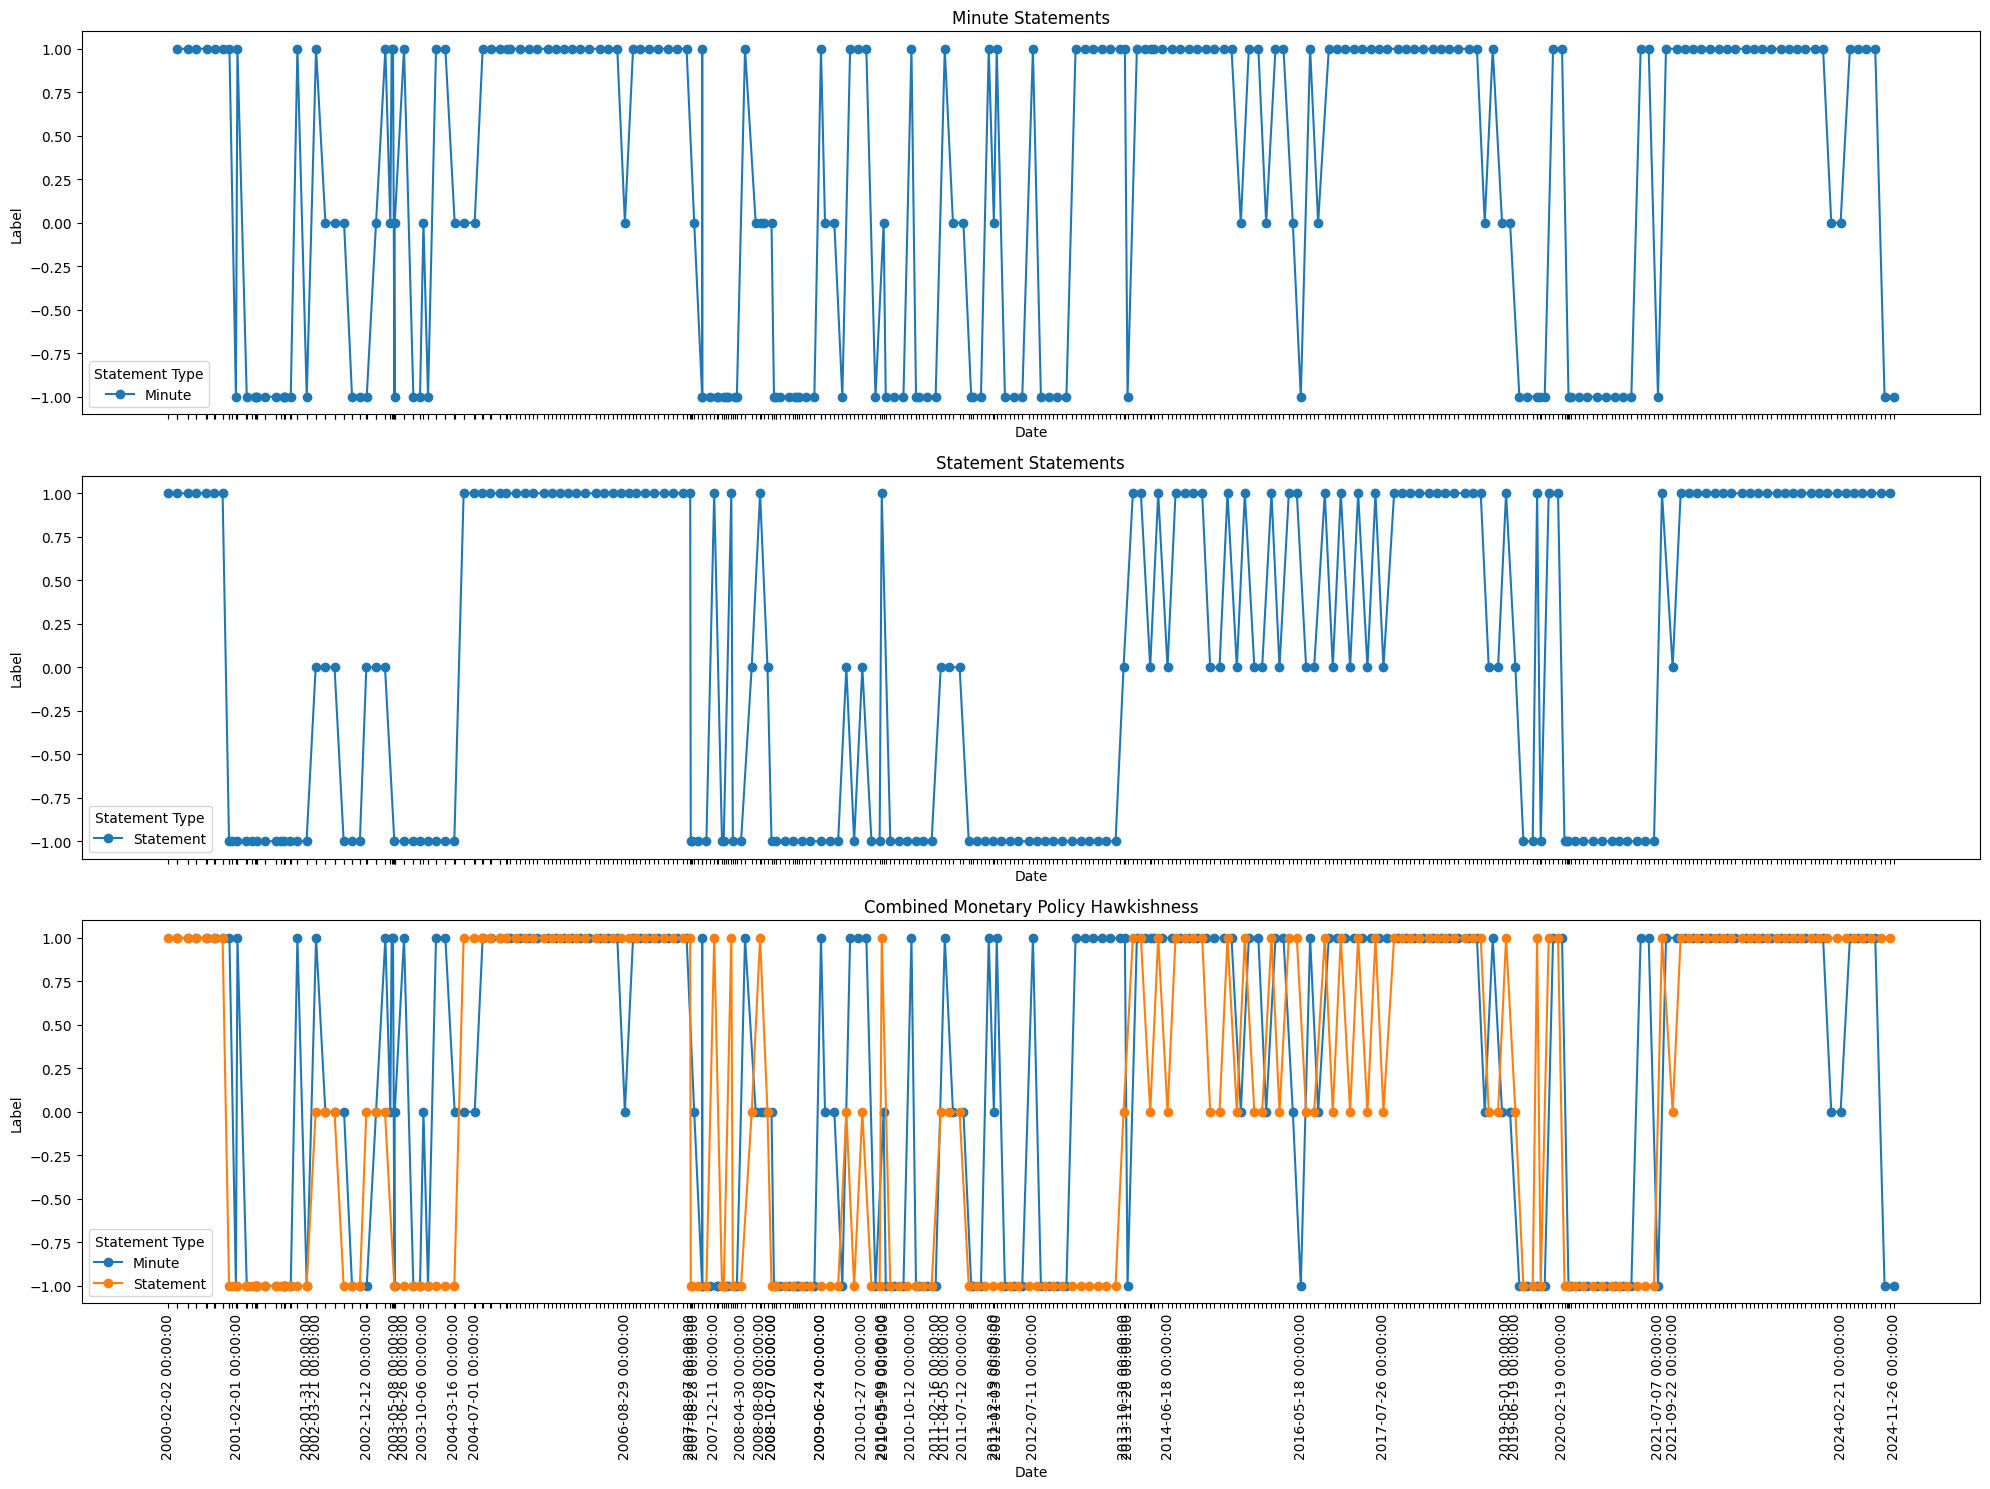

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Date2 is datetime and sorted
df['Date2'] = pd.to_datetime(df['Release Date'])
df = df.sort_values(by='Date2', ascending=False)

# Encode labels
df['label2'] = df['label'].apply(lambda x: 1 if x == 'hawkish' else 0 if x == 'neutral' else -1)

# Identify important shifts
df['shift_date'] = check_important_shift_dates(df, 5)

# Initialize subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

# Plot each statement type separately
for ax, (statement_type, group_df) in zip(axes[:2], df.groupby('Type')):
    ax.plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
    ax.set_title(f'{statement_type} Statements')
    ax.set_xlabel('Date')
    ax.set_ylabel('Label')
    ax.legend(title="Statement Type")

# Plot both together in the last subplot
for statement_type, group_df in df.groupby('Type'):
    axes[2].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)

# Customize final plot
axes[2].set_title('Combined Monetary Policy Hawkishness')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Label')
axes[2].legend(title="Statement Type")

# Customize x-ticks across all plots
xticks_labels = [df['Date2'].iloc[i] if i == 0 or i == len(df) - 1 or df['shift_date'].iloc[i] else '' 
                 for i in range(len(df))]
plt.xticks(df['Date2'], labels=xticks_labels, rotation=90)

# Show the plots
plt.tight_layout()
plt.show()


### Professor's results with OpenAI Key to cross validate :
- 1999 - 2001: tightening until the dot-com burst (Hawkish) <span style="color:green">Same for us.</span>
- 2001 - 2004: loosening of monetary policy (Dovish) <span style="color:yellow">Lots of noise but same.</span>
- 2004 - 2007: tightening (Hawkish) <span style="color:green">Same for us.</span>
- 2007 - 2017: long experiment with loosening, including with Quantitative Easing (Dovish) <span style="color:red">Our graph does not really show the same thing especially in 2014-2017.</span>
- 2017 - 2019: Quantitative tightening (Hawkish) <span style="color:green">Same for us.</span>
- 2019 - 2021: economic slowdown (2019) preceding the Covid intervention (Dovish) <span style="color:green">more from 2020</span>
- 2022 - today: tightening due to high inflation (Hawkish) <span style="color:green">Maybe new trends for 2024 ?</span>

NB: 
- Hawkish: Taux d'interets augmentent pour lutter contre l'inflation (s'applique pendant une période de croissance économique. C'est un positionnement favorable à l'appréciation de la devise du pays sur le marché des changes.)

- Dovish : a pour objectif la croissance économique et rien d'autre.
Généralement, une politique « Dovish » se traduit par une baisse des taux d'intérêt et l'utilisation de mesures non conventionnelles comme le « Quantitative Easing ».
se mène le plus souvent lors d'une période de récession. propice à la dépréciation d'une monnaie sur le forex.

## Georgia Tech's Finetuned Roberta

LABEL_2: Neutral
LABEL_1: Hawkish
LABEL_0: Dovish

In [15]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, device=0, framework="pt")


Device set to use cuda:0


In [16]:
results = classifier(communications['Text'].tolist(),
                      batch_size=128, truncation="only_first")


In [17]:
results_explanation = classifier(communications['Mistral_explanation'].tolist(),
                                    batch_size=128, truncation="only_first")

In [18]:
#add them tp the communications dataframe
communications['RoBERTa_label_raw']=pd.DataFrame(results)['label'].map({'LABEL_0':'dovish','LABEL_1':'hawkish','LABEL_2':'Neutral'})
communications['RoBERTa_probability_raw']=pd.DataFrame(results)['score']
communications['RoBERTa_label_explanation']=pd.DataFrame(results_explanation)['label'].map({'LABEL_0':'dovish','LABEL_1':'hawkish','LABEL_2':'Neutral'})
communications['RoBERTa_probability_explanation']=pd.DataFrame(results_explanation)['score']

In [19]:
#compute accuracy 
from sklearn.metrics import accuracy_score

acc_llm_roberta_raw=accuracy_score(communications['label'],communications['RoBERTa_label_raw'])
acc_llm_roberta_explanation=accuracy_score(communications['label'],communications['RoBERTa_label_explanation'])
acc_roberta_raw_roberta_explanation=accuracy_score(communications['RoBERTa_label_raw'],communications['RoBERTa_label_explanation'])
print(f'Accuracy of LLM vs RoBERTa raw: {acc_llm_roberta_raw}')
print(f'Accuracy of LLM vs RoBERTa explanation: {acc_llm_roberta_explanation}')
print(f'Accuracy of RoBERTa raw vs RoBERTa explanation: {acc_roberta_raw_roberta_explanation}')
#accuracy by type (Minute/ Statement)
print('\n'+'---'*20+'\n')
for t in ['Minute','Statement']:
    acc_llm_roberta_raw=accuracy_score(communications[communications['Type']==t]['label'],communications[communications['Type']==t]['RoBERTa_label_raw'])
    acc_llm_roberta_explanation=accuracy_score(communications[communications['Type']==t]['label'],communications[communications['Type']==t]['RoBERTa_label_explanation'])
    acc_roberta_raw_roberta_explanation=accuracy_score(communications[communications['Type']==t]['RoBERTa_label_raw'],communications[communications['Type']==t]['RoBERTa_label_explanation'])
    print(f'Accuracy of LLM vs RoBERTa raw for {t}: {acc_llm_roberta_raw}') 
    print(f'Accuracy of LLM vs RoBERTa explanation for {t}: {acc_llm_roberta_explanation}')
    print(f'Accuracy of RoBERTa raw vs RoBERTa explanation for {t}: {acc_roberta_raw_roberta_explanation}')
    print('\n'+'---'*20+'\n')

Accuracy of LLM vs RoBERTa raw: 0.3431818181818182
Accuracy of LLM vs RoBERTa explanation: 0.6909090909090909
Accuracy of RoBERTa raw vs RoBERTa explanation: 0.5227272727272727

------------------------------------------------------------

Accuracy of LLM vs RoBERTa raw for Minute: 0.004366812227074236
Accuracy of LLM vs RoBERTa explanation for Minute: 0.6200873362445415
Accuracy of RoBERTa raw vs RoBERTa explanation for Minute: 0.24017467248908297

------------------------------------------------------------

Accuracy of LLM vs RoBERTa raw for Statement: 0.7109004739336493
Accuracy of LLM vs RoBERTa explanation for Statement: 0.7677725118483413
Accuracy of RoBERTa raw vs RoBERTa explanation for Statement: 0.8293838862559242

------------------------------------------------------------



In [20]:
df=copy.deepcopy(communications)

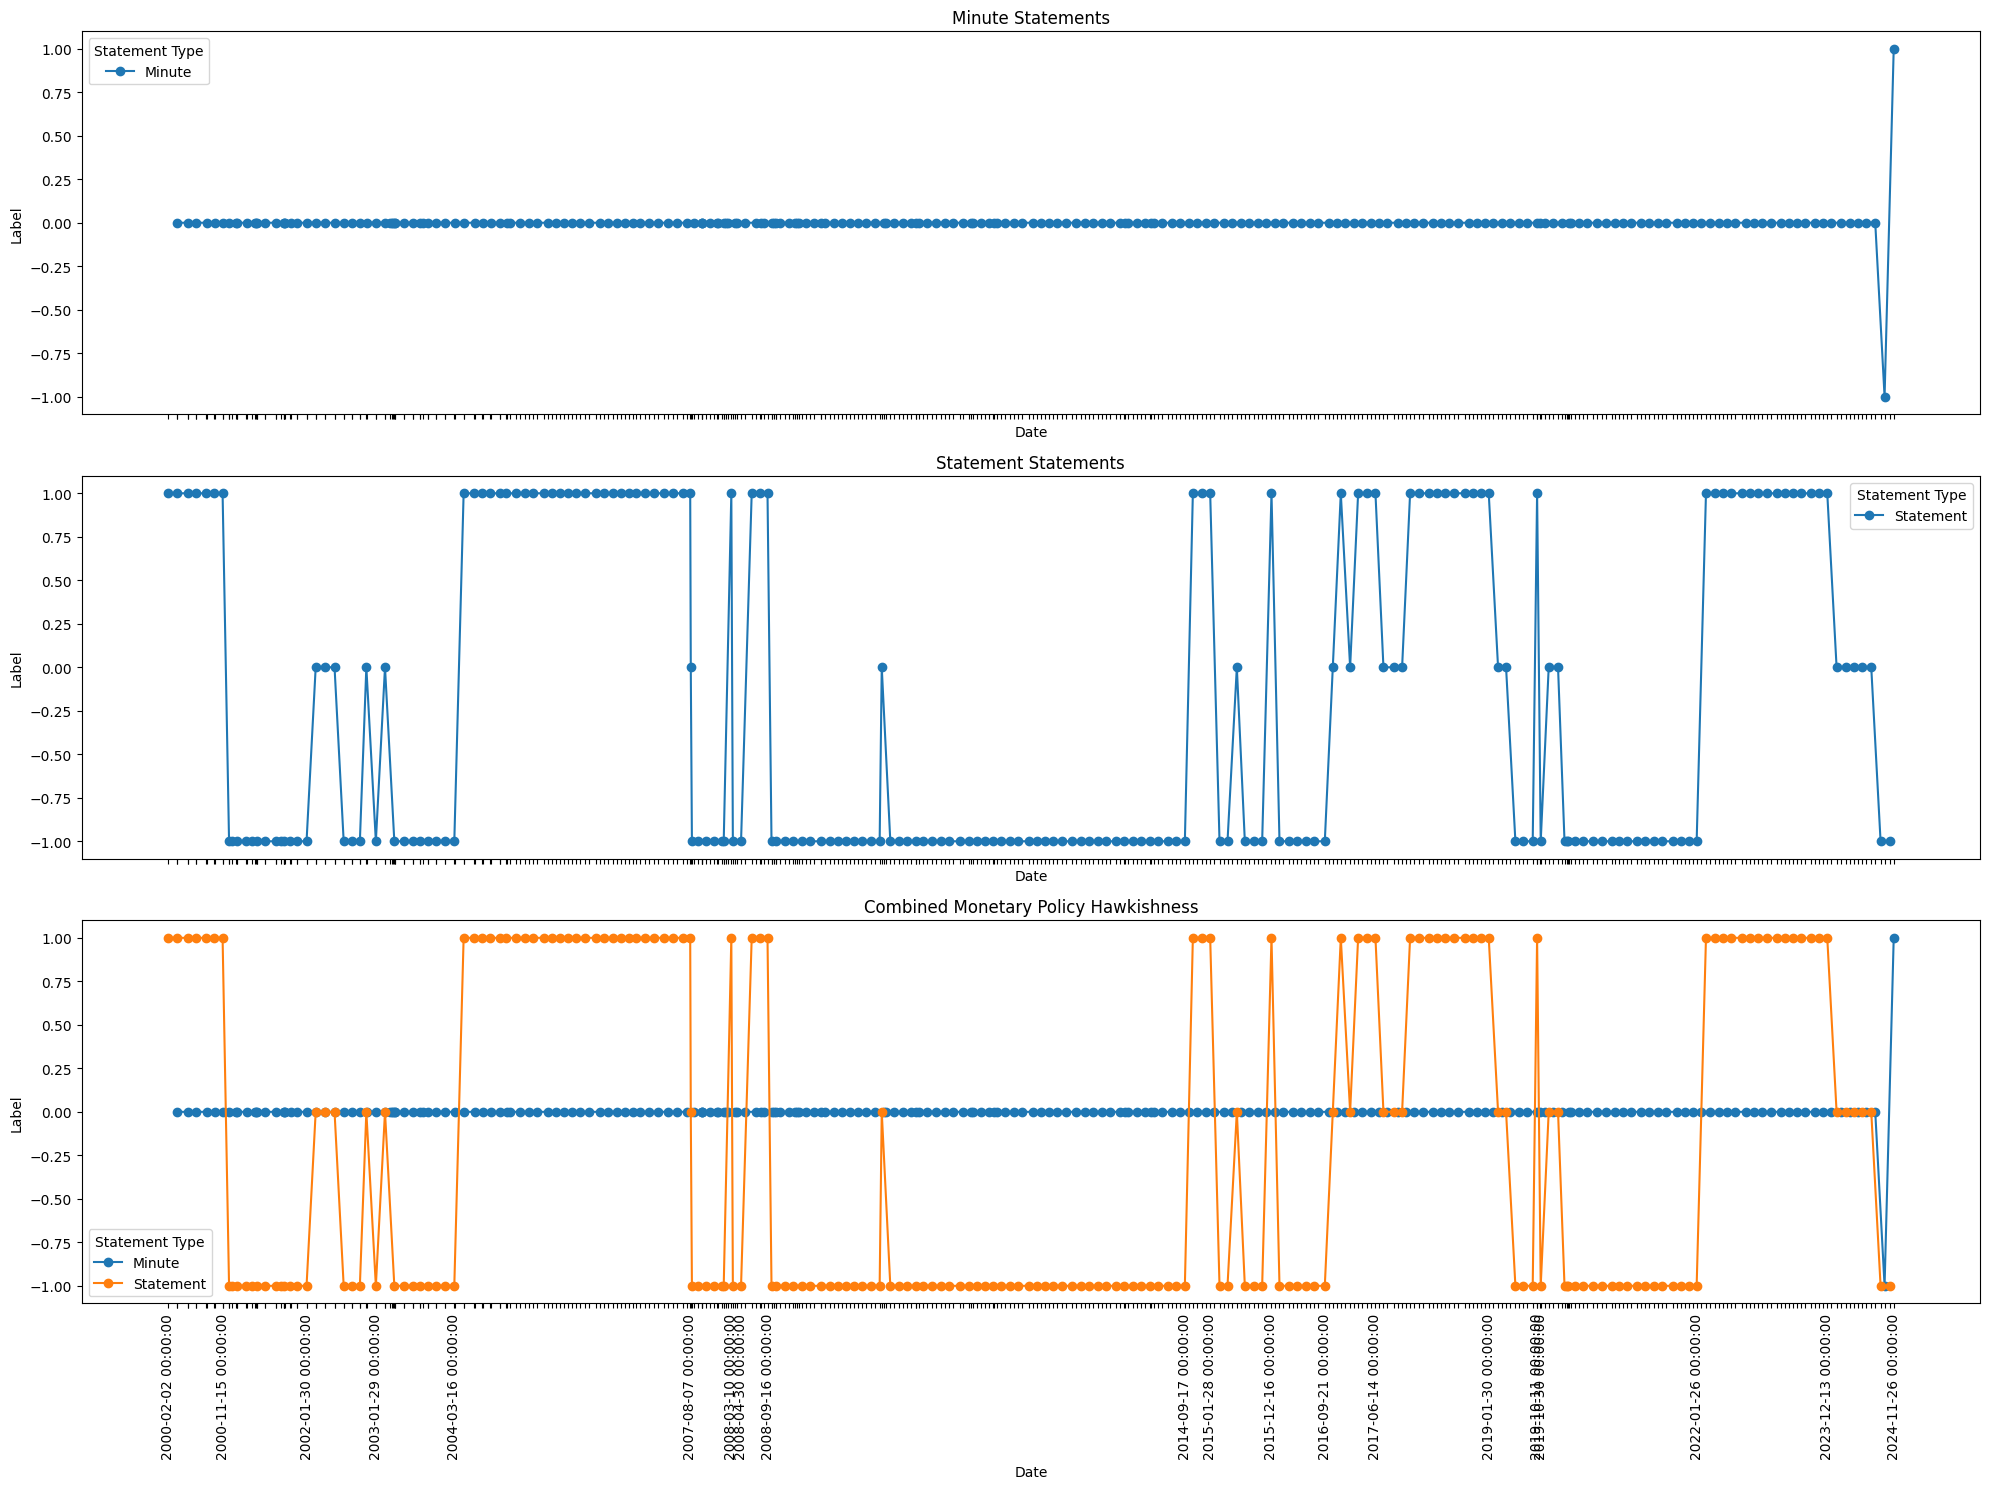

In [21]:
# Ensure Date2 is datetime and sorted
df['Date2'] = pd.to_datetime(df['Release Date'])
df = df.sort_values(by='Date2', ascending=False)


# Encode labels
df['label2'] = df['RoBERTa_label_raw'].apply(lambda x: 1 if x == 'hawkish' else 0 if x == 'Neutral' else -1)

# Identify important shifts
df['shift_date'] = check_important_shift_dates(df, 5)

# Initialize subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

# Plot each statement type separately
for ax, (statement_type, group_df) in zip(axes[:2], df.groupby('Type')):
    ax.plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
    ax.set_title(f'{statement_type} Statements')
    ax.set_xlabel('Date')
    ax.set_ylabel('Label')
    ax.legend(title="Statement Type")

# Plot both together in the last subplot
for statement_type, group_df in df.groupby('Type'):
    axes[2].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)

# Customize final plot
axes[2].set_title('Combined Monetary Policy Hawkishness')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Label')
axes[2].legend(title="Statement Type")

# Customize x-ticks across all plots
xticks_labels = [df['Date2'].iloc[i] if i == 0 or i == len(df) - 1 or df['shift_date'].iloc[i] else '' 
                 for i in range(len(df))]
plt.xticks(df['Date2'], labels=xticks_labels, rotation=90)

# Show the plots
plt.tight_layout()
plt.show()


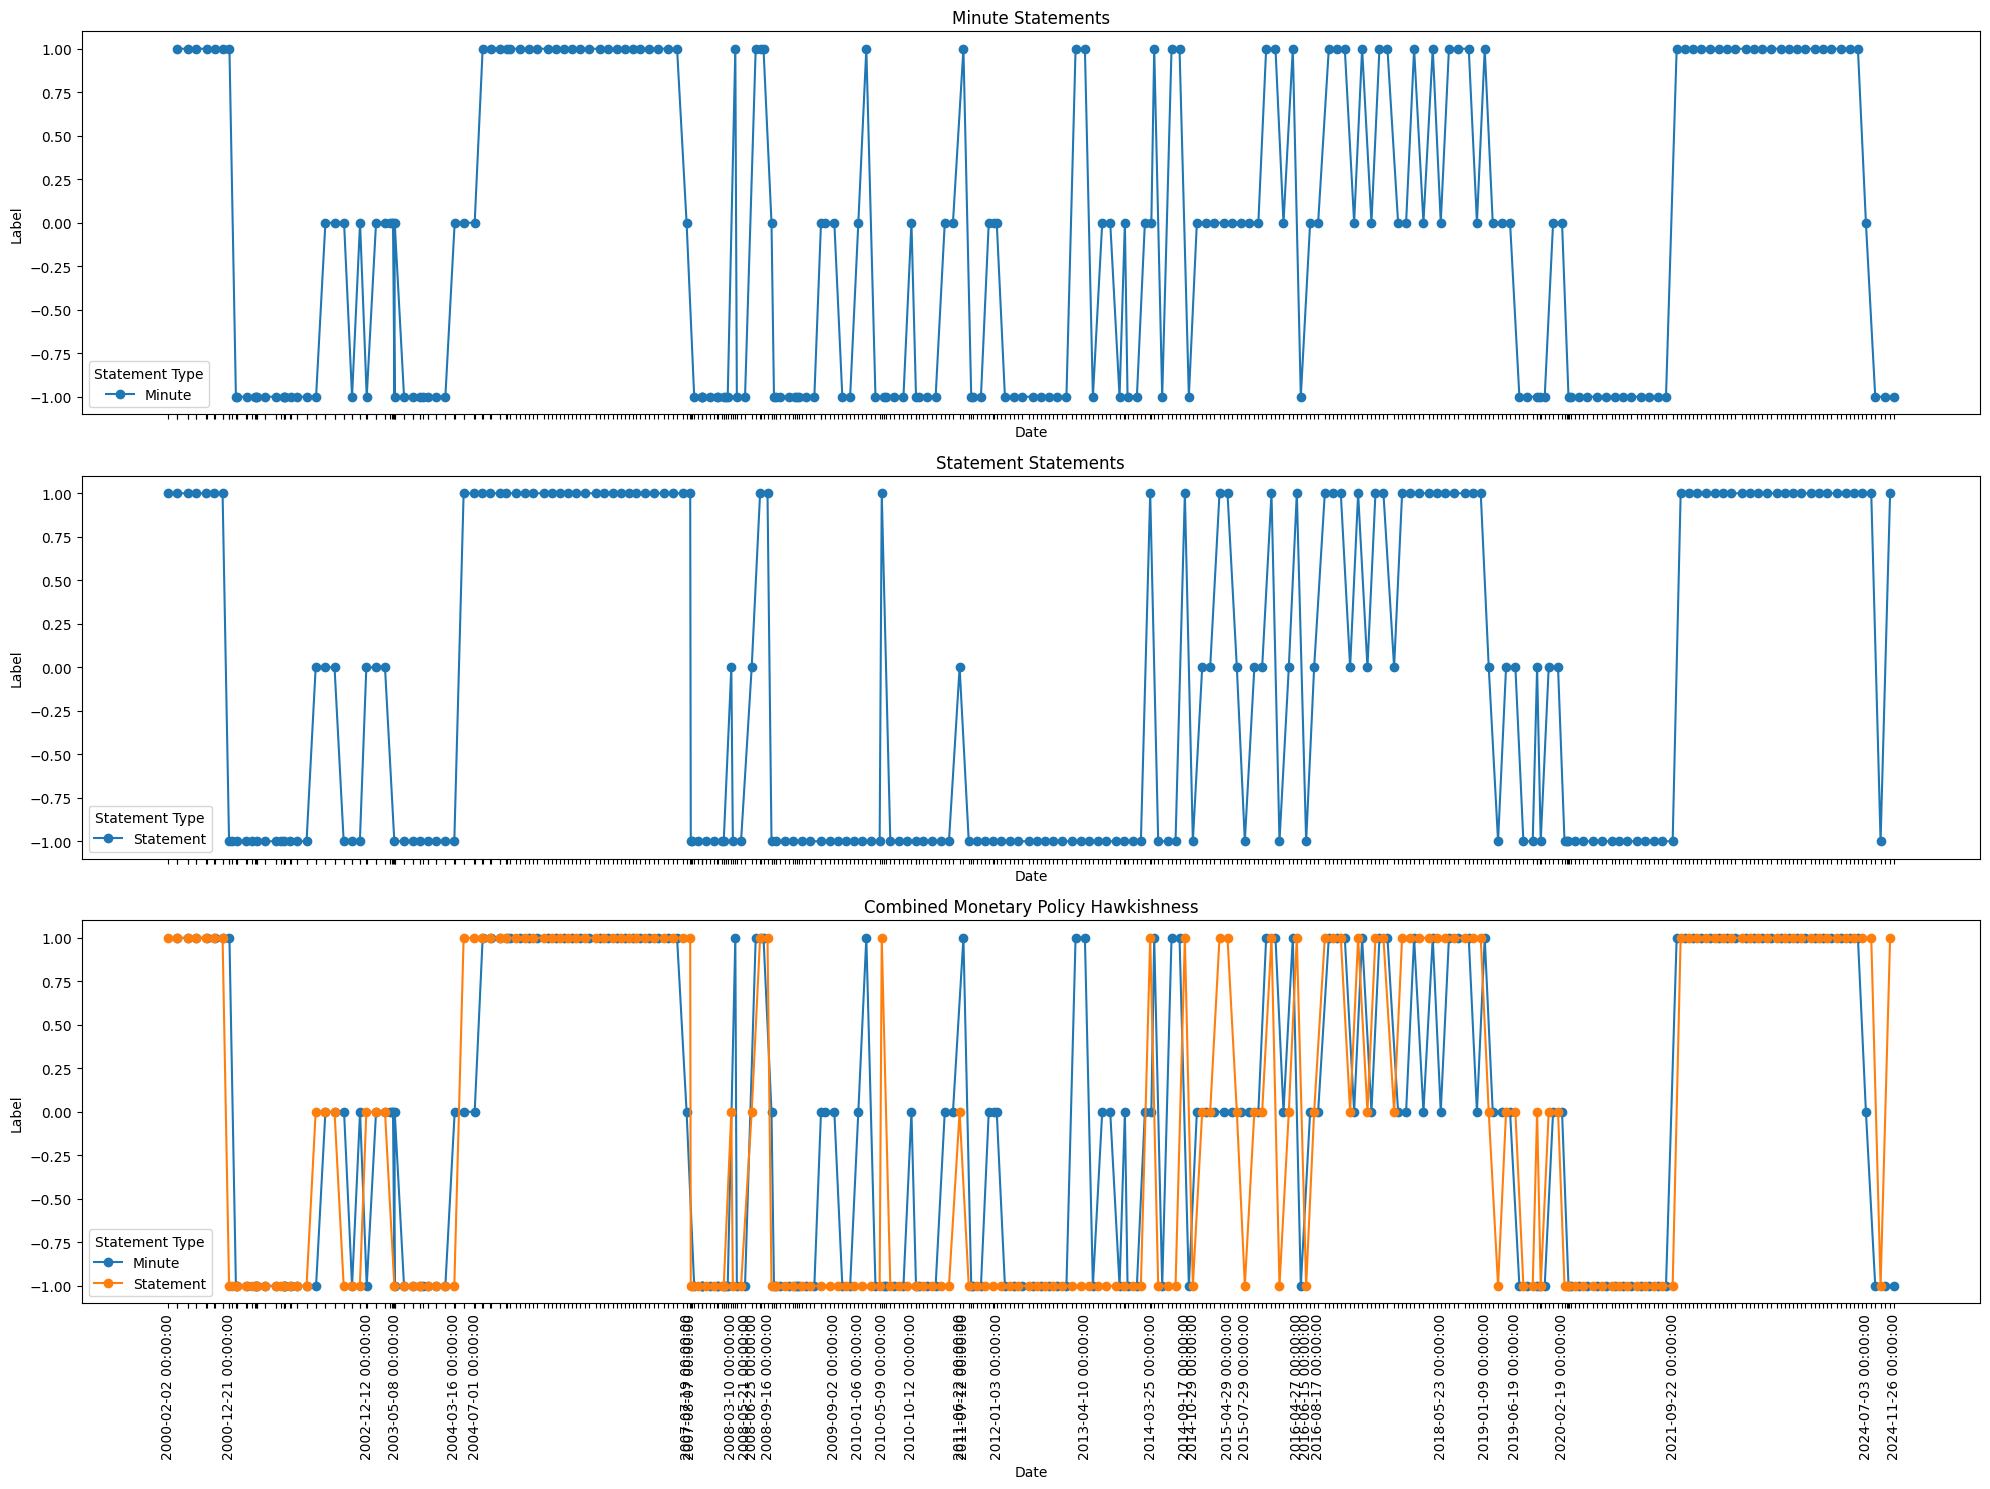

In [22]:
# Ensure Date2 is datetime and sorted
df['Date2'] = pd.to_datetime(df['Release Date'])
df = df.sort_values(by='Date2', ascending=False)


# Encode labels
df['label2'] = df['RoBERTa_label_explanation'].apply(lambda x: 1 if x == 'hawkish' else 0 if x == 'Neutral' else -1)

# Identify important shifts
df['shift_date'] = check_important_shift_dates(df, 5)

# Initialize subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

# Plot each statement type separately
for ax, (statement_type, group_df) in zip(axes[:2], df.groupby('Type')):
    ax.plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
    ax.set_title(f'{statement_type} Statements')
    ax.set_xlabel('Date')
    ax.set_ylabel('Label')
    ax.legend(title="Statement Type")

# Plot both together in the last subplot
for statement_type, group_df in df.groupby('Type'):
    axes[2].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)

# Customize final plot
axes[2].set_title('Combined Monetary Policy Hawkishness')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Label')
axes[2].legend(title="Statement Type")

# Customize x-ticks across all plots
xticks_labels = [df['Date2'].iloc[i] if i == 0 or i == len(df) - 1 or df['shift_date'].iloc[i] else '' 
                 for i in range(len(df))]
plt.xticks(df['Date2'], labels=xticks_labels, rotation=90)

# Show the plots
plt.tight_layout()
plt.show()


It seems Georgia Tech's model does not really perform well with Minutes. It's hard to evaluate which one performs better on Statements as we have no baseline/GT. We have Results from Mistral-Large and GeorgiaTech's finetuned Roberta and the Professor's Summary of GPT-4o' results (which seem to corroborate Roberta's result but i think a big part of those statments are in the training set). All text processing methods. Can we find a result Numerically ? using interest rates, employment rates etc ?

In [23]:
# Define the URL for the CSV download
csv_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=INTDSRUSM193N&scale=left&cosd=1950-01-01&coed=2021-08-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-12-18&revision_date=2024-12-18&nd=1950-01-01"

#Interest Rates, Discount Rate for United States

# Download the CSV file into a DataFrame
Int_R = pd.read_csv(csv_url)
#keep observations from 2000 onwards
Int_R=Int_R[Int_R['observation_date']>='2000-01-01']
Int_R['evolution']=Int_R['INTDSRUSM193N'].diff(1)
Int_R['evolution_pct']=Int_R['INTDSRUSM193N'].pct_change(1)*100
Int_R

,observation_date,INTDSRUSM193N,evolution,evolution_pct
600,2000-01-01,5.00,NaN,NaN
601,2000-02-01,5.24,0.24,4.800000
602,2000-03-01,5.34,0.10,1.908397
603,2000-04-01,5.50,0.16,2.996255
604,2000-05-01,5.71,0.21,3.818182
...,...,...,...,...
855,2021-04-01,0.25,0.00,0.000000
856,2021-05-01,0.25,0.00,0.000000
857,2021-06-01,0.25,0.00,0.000000
858,2021-07-01,0.25,0.00,0.000000


In [24]:
# Define the URL for the CSV download
csv_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIAUCSL&scale=left&cosd=1947-01-01&coed=2024-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-12-18&revision_date=2024-12-18&nd=1947-01-01"

#Consumer Price Index for All Urban Consumers: All Items in U.S. City Average

# Download the CSV file into a DataFrame
CPI = pd.read_csv(csv_url)
#keep observations from 2000 onwards
CPI=CPI[CPI['observation_date']>='2000-01-01']
CPI['evolution']=CPI['CPIAUCSL'].diff(1)
CPI['evolution_pct']=CPI['CPIAUCSL'].pct_change(1)*100
CPI


,observation_date,CPIAUCSL,evolution,evolution_pct
636,2000-01-01,169.300,NaN,NaN
637,2000-02-01,170.000,0.700,0.413467
638,2000-03-01,171.000,1.000,0.588235
639,2000-04-01,170.900,-0.100,-0.058480
640,2000-05-01,171.200,0.300,0.175541
...,...,...,...,...
930,2024-07-01,313.534,0.485,0.154928
931,2024-08-01,314.121,0.587,0.187221
932,2024-09-01,314.686,0.565,0.179867
933,2024-10-01,315.454,0.768,0.244053


In [25]:
# Define the URL for the CSV download
csv_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=UNRATE&scale=left&cosd=1948-01-01&coed=2024-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-12-18&revision_date=2024-12-18&nd=1948-01-01"

#Unepmloyment Rate

# Download the CSV file into a DataFrame
UR = pd.read_csv(csv_url)
#keep observations from 2000 onwards
UR=UR[UR['observation_date']>='2000-01-01']
UR['evolution']=UR['UNRATE'].diff(1)
UR['evolution_pct']=UR['UNRATE'].pct_change(1)*100
UR.head()

,observation_date,UNRATE,evolution,evolution_pct
624,2000-01-01,4.0,NaN,NaN
625,2000-02-01,4.1,0.1,2.500000
626,2000-03-01,4.0,-0.1,-2.439024
627,2000-04-01,3.8,-0.2,-5.000000
628,2000-05-01,4.0,0.2,5.263158


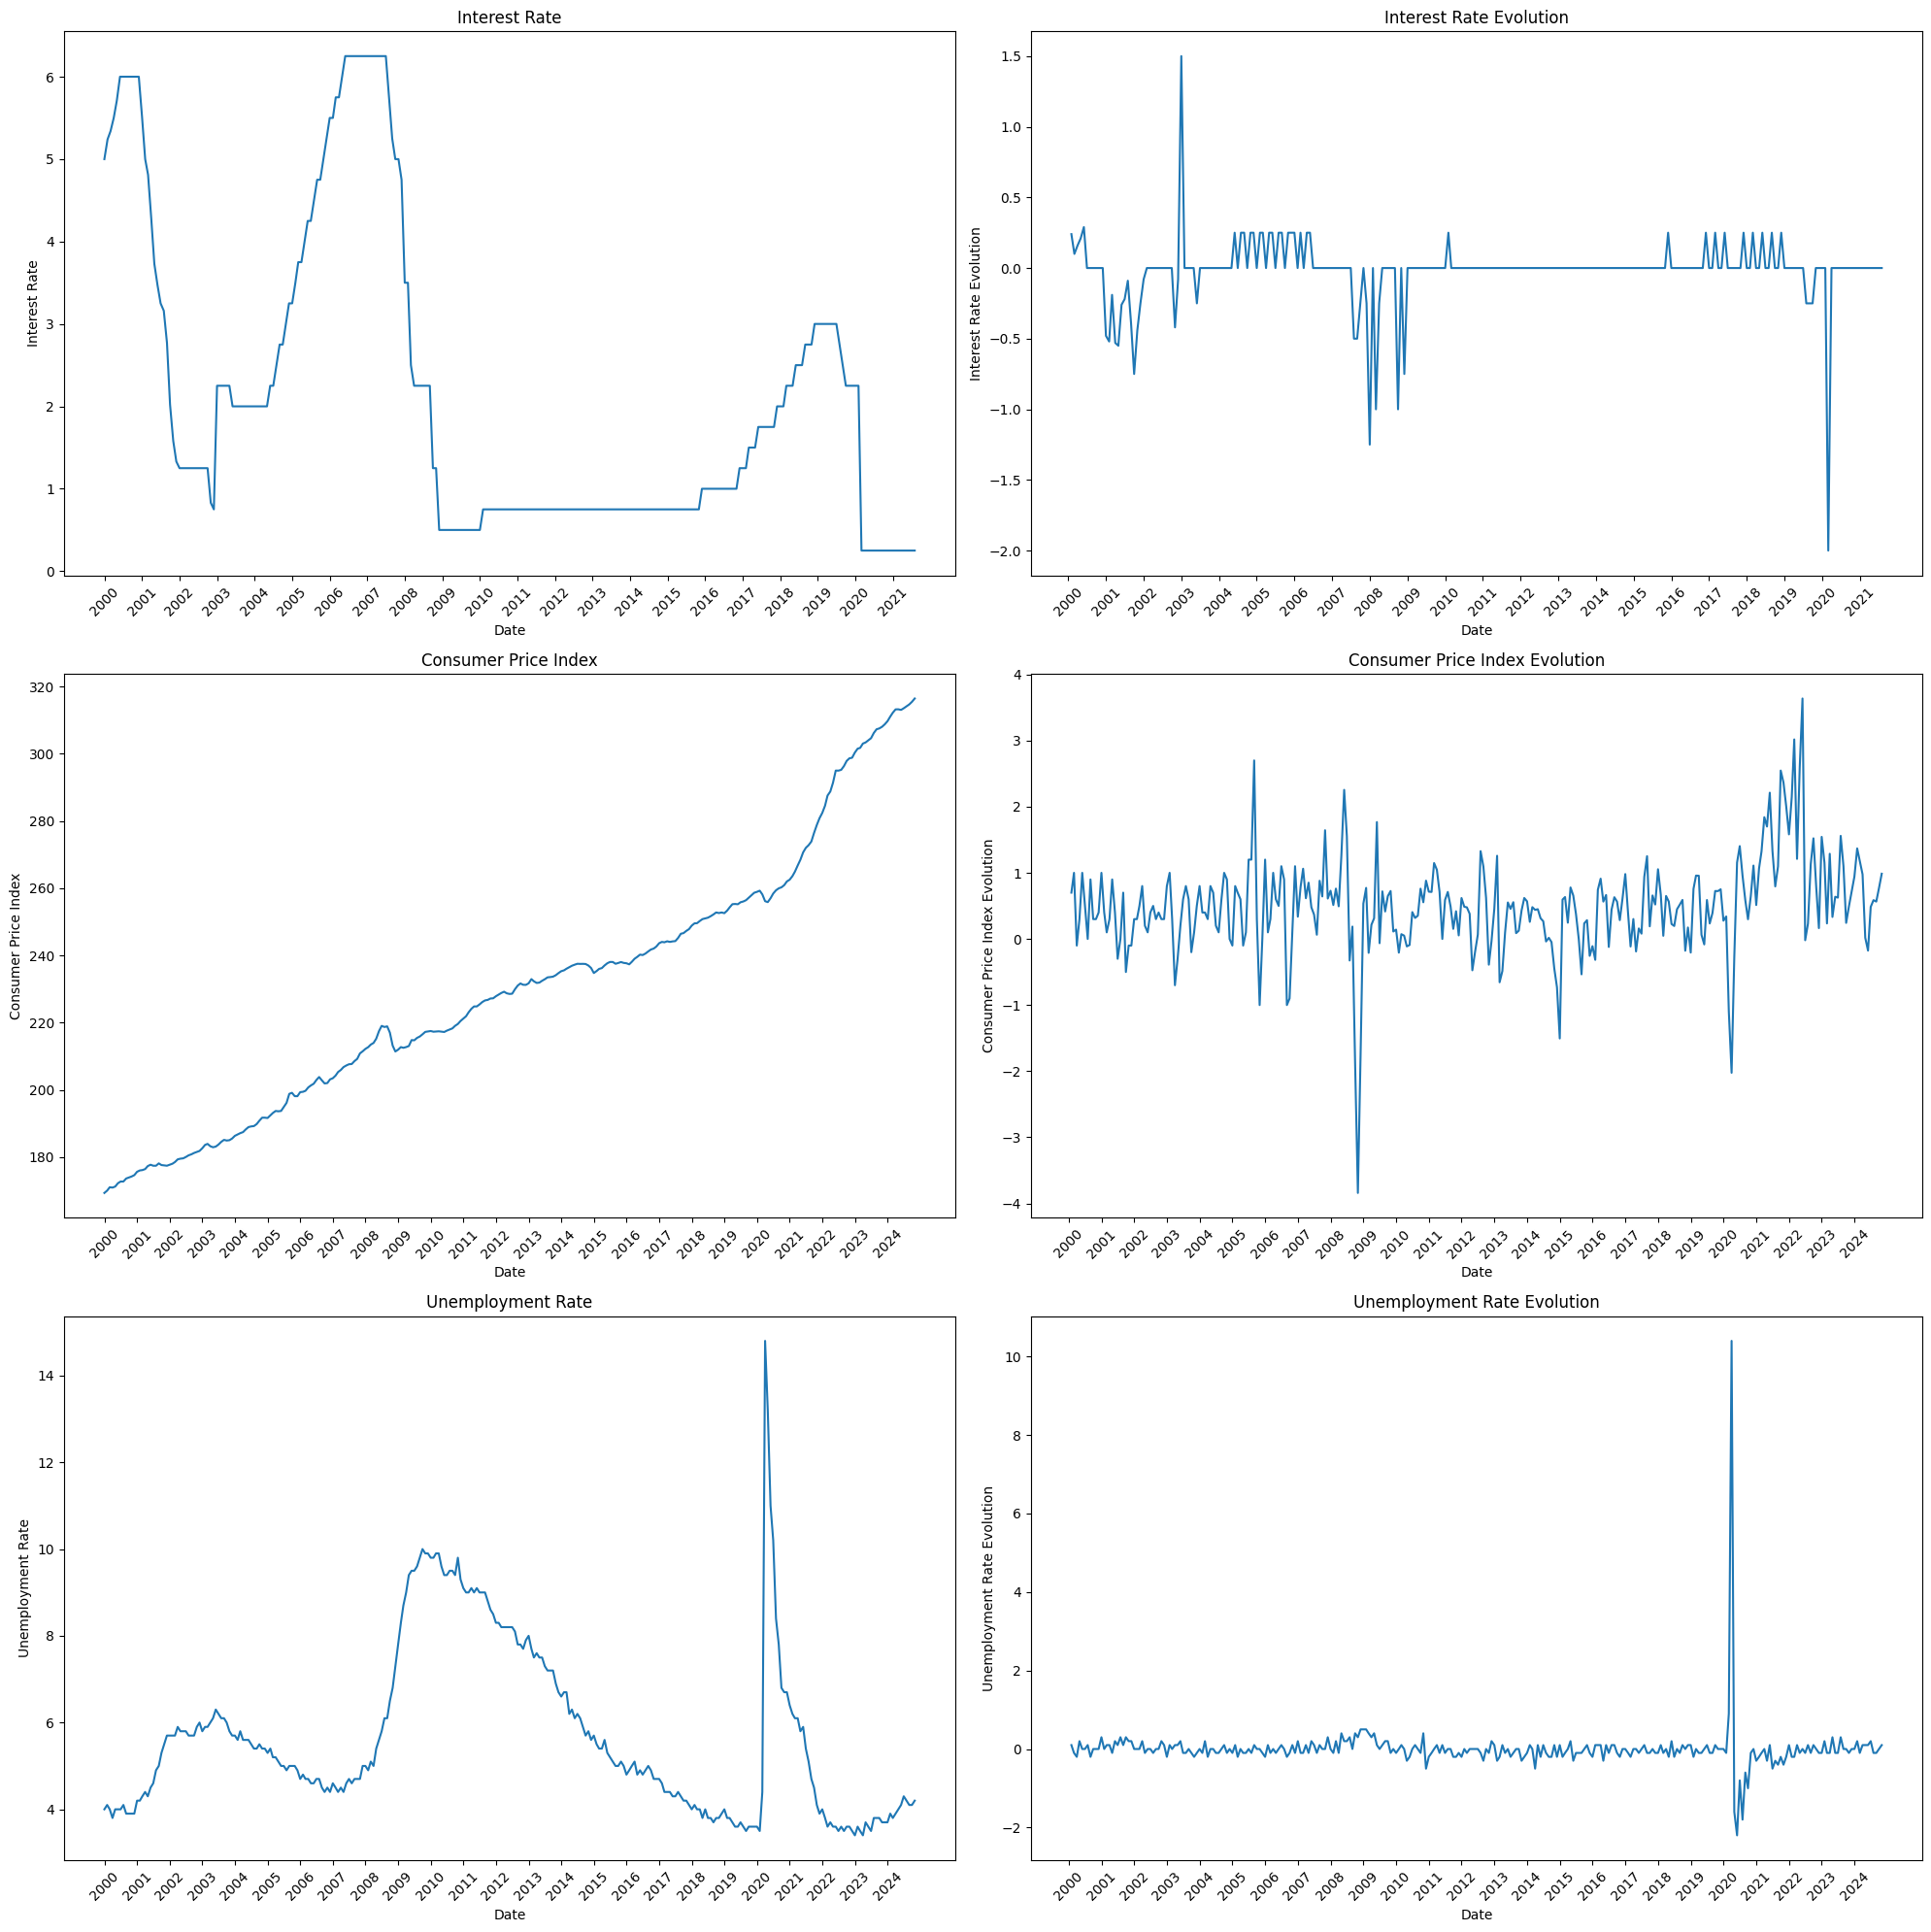

In [26]:
Int_R['observation_date'] = pd.to_datetime(Int_R['observation_date'])
CPI['observation_date'] = pd.to_datetime(CPI['observation_date'])
UR['observation_date'] = pd.to_datetime(UR['observation_date'])
jan_first_dates = Int_R['observation_date'][Int_R['observation_date'].dt.strftime('%m-%d') == '01-01']
jan_first_dates_CPI = CPI['observation_date'][CPI['observation_date'].dt.strftime('%m-%d') == '01-01']
jan_first_dates_UR = UR['observation_date'][UR['observation_date'].dt.strftime('%m-%d') == '01-01']

fig, ax = plt.subplots(3,2,figsize=(20,20))

ax[0,0].plot(Int_R['observation_date'],Int_R['INTDSRUSM193N'])
ax[0,0].set_title('Interest Rate')
ax[0,0].set_ylabel('Interest Rate')
ax[0,0].set_xlabel('Date')
ax[0,0].set_xticks(jan_first_dates)
ax[0,0].set_xticklabels(jan_first_dates.dt.strftime('%Y'),rotation=45)


ax[0,1].plot(Int_R['observation_date'],Int_R['evolution'])
ax[0,1].set_title('Interest Rate Evolution')
ax[0,1].set_ylabel('Interest Rate Evolution')
ax[0,1].set_xlabel('Date')
ax[0,1].set_xticks(jan_first_dates)
ax[0,1].set_xticklabels(jan_first_dates.dt.strftime('%Y'),rotation=45)



ax[1,0].plot(CPI['observation_date'],CPI['CPIAUCSL'])
ax[1,0].set_title('Consumer Price Index')
ax[1,0].set_ylabel('Consumer Price Index')
ax[1,0].set_xlabel('Date')
ax[1,0].set_xticks(jan_first_dates_CPI)
ax[1,0].set_xticklabels(jan_first_dates_CPI.dt.strftime('%Y'),rotation=45)

ax[1,1].plot(CPI['observation_date'],CPI['evolution'])
ax[1,1].set_title('Consumer Price Index Evolution')
ax[1,1].set_ylabel('Consumer Price Index Evolution')
ax[1,1].set_xlabel('Date')
ax[1,1].set_xticks(jan_first_dates_CPI)
ax[1,1].set_xticklabels(jan_first_dates_CPI.dt.strftime('%Y'),rotation=45)

ax[2,0].plot(UR['observation_date'],UR['UNRATE'])
ax[2,0].set_title('Unemployment Rate')
ax[2,0].set_ylabel('Unemployment Rate')
ax[2,0].set_xlabel('Date')
ax[2,0].set_xticks(jan_first_dates_UR)
ax[2,0].set_xticklabels(jan_first_dates_UR.dt.strftime('%Y'),rotation=45)

ax[2,1].plot(UR['observation_date'],UR['evolution'])
ax[2,1].set_title('Unemployment Rate Evolution')
ax[2,1].set_ylabel('Unemployment Rate Evolution')
ax[2,1].set_xlabel('Date')
ax[2,1].set_xticks(jan_first_dates_UR)
ax[2,1].set_xticklabels(jan_first_dates_UR.dt.strftime('%Y'),rotation=45)

plt.tight_layout()
plt.show()



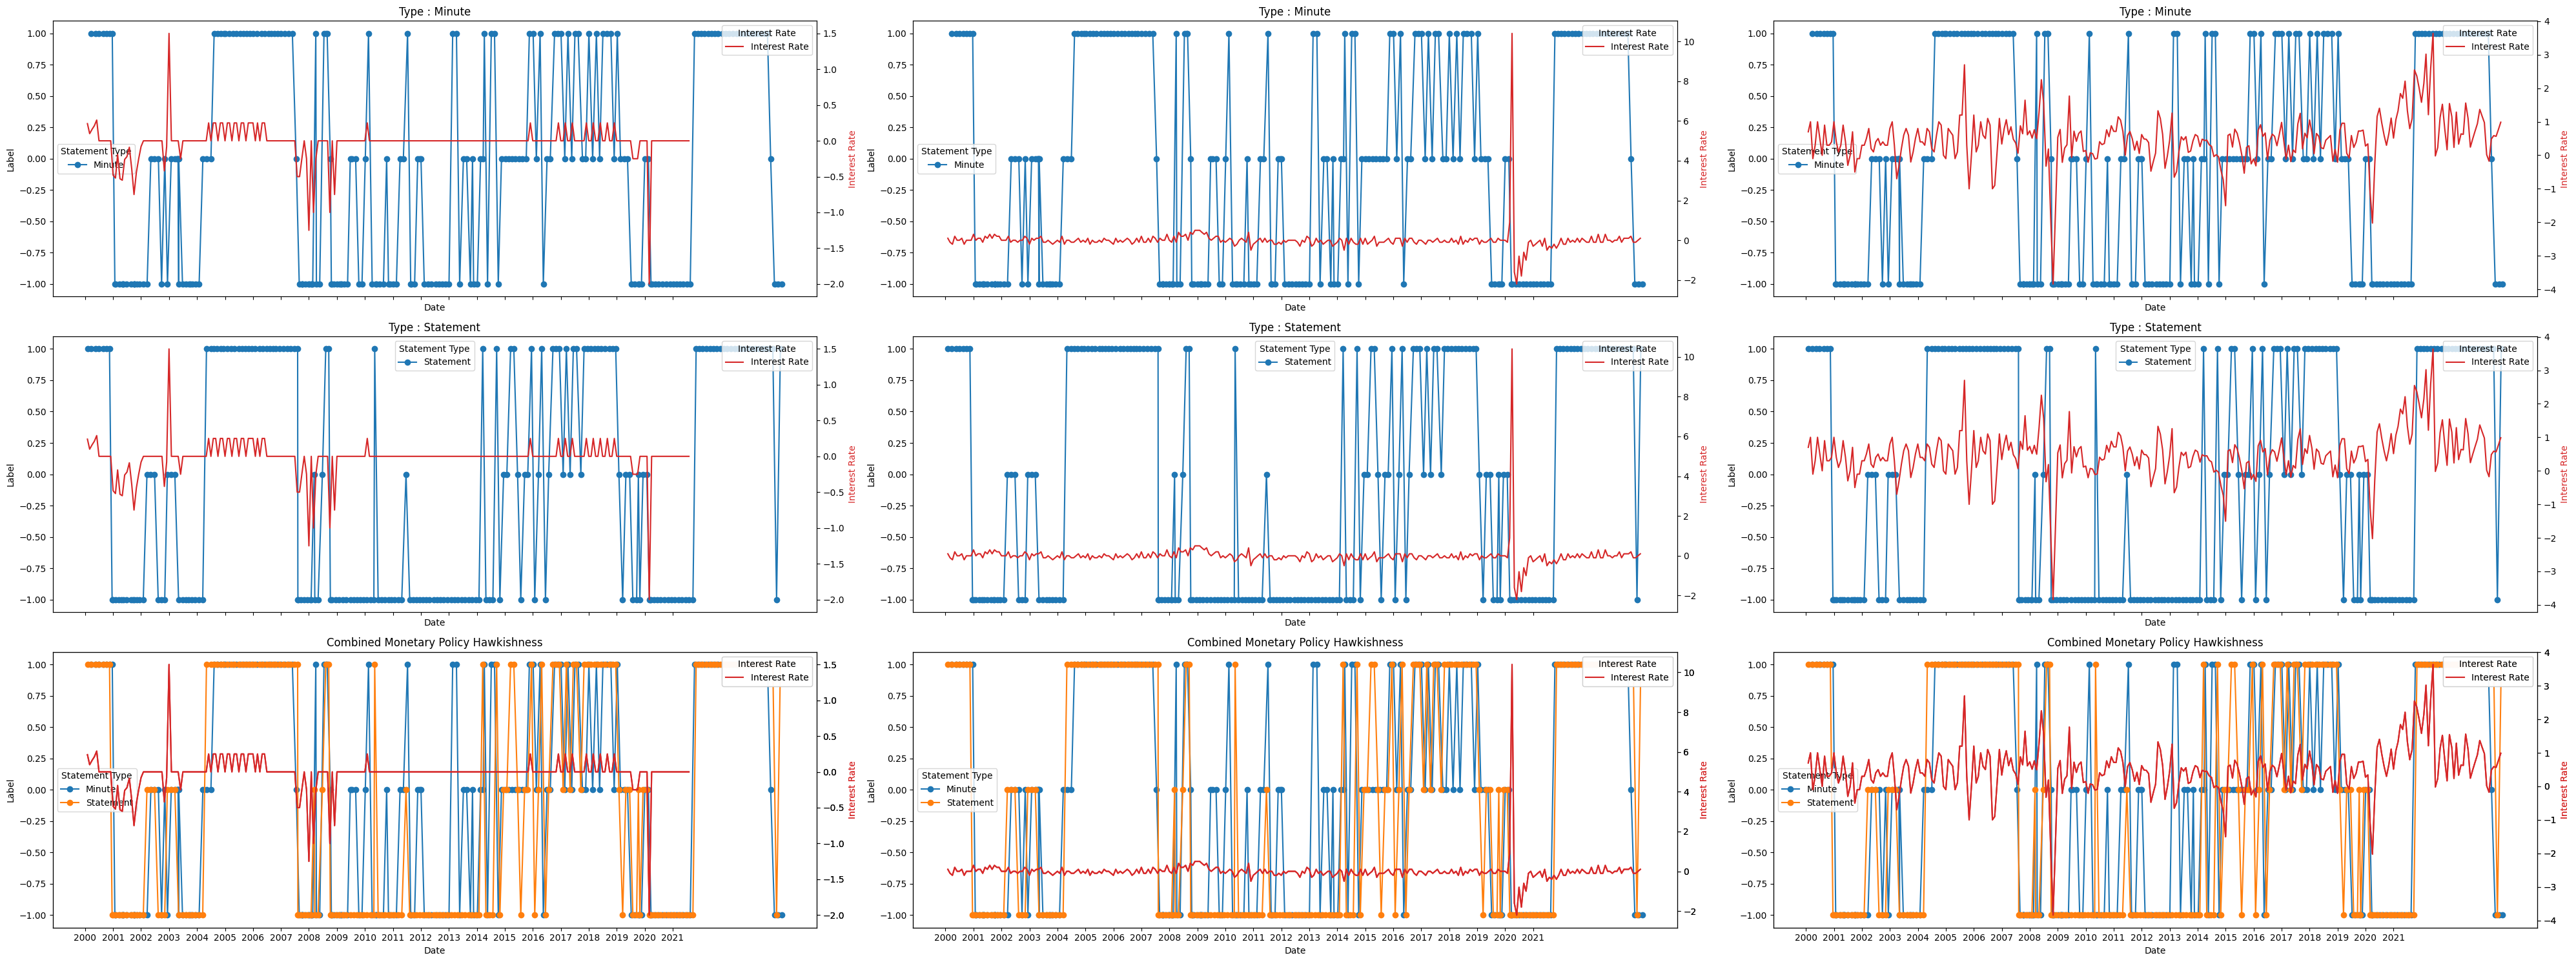

In [27]:
df=copy.deepcopy(communications)
# Ensure Date2 is datetime and sorted
df['Date2'] = pd.to_datetime(df['Release Date'])
df = df.sort_values(by='Date2', ascending=False)


# Encode labels
df['label2'] = df['RoBERTa_label_explanation'].apply(lambda x: 1 if x == 'hawkish' else 0 if x == 'Neutral' else -1)

# Identify important shifts
df['shift_date'] = check_important_shift_dates(df, 5)

# Initialize subplots
fig, axes = plt.subplots(3, 3, figsize=(40, 15), sharex=True)

# Plot each statement type separately
for i, (statement_type, group_df) in enumerate(df.groupby('Type')):
        for j, variable in enumerate([Int_R,UR,CPI]):
            axes[i,j].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
            axes[i,j].set_title(f'Type : {statement_type}')
            axes[i,j].set_xlabel('Date')
            axes[i,j].set_ylabel('Label')
            axes[i,j].legend(title="Statement Type")
            
            ax2 = axes[i,j].twinx()  # This creates a second y-axis sharing the same x-axis
            ax2.plot(variable['observation_date'], variable['evolution'], color='tab:red', label='Interest Rate')
            ax2.set_ylabel('Interest Rate', color='tab:red')  # Set the y-axis label for the second plot
            ax2.set_xticks(jan_first_dates)
            ax2.set_xticklabels(jan_first_dates.dt.strftime('%Y'), rotation=45, ha='right')
    
            # Optional: Set a legend for the second y-axis
            ax2.legend(title="Interest Rate", loc='upper right')
            
            
            

# Plot both together in the last subplot
for statement_type, group_df in df.groupby('Type'):
    for j, variable in enumerate([Int_R,UR,CPI]):
        axes[2,j].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
        axes[2,j].set_title('Combined Monetary Policy Hawkishness')
        axes[2,j].set_xlabel('Date')
        axes[2,j].set_ylabel('Label')
        axes[2,j].legend(title="Statement Type")

        ax2 = axes[2,j].twinx()
        ax2.plot(variable['observation_date'], variable['evolution'], color='tab:red', label='Interest Rate')
        ax2.set_ylabel('Interest Rate', color='tab:red')
        ax2.set_xticks(jan_first_dates)
        ax2.set_xticklabels(jan_first_dates.dt.strftime('%Y'), rotation=45, ha='right')
        ax2.legend(title="Interest Rate", loc='upper right')
        
        

# Show the plots
plt.tight_layout()
plt.show()

In [73]:
from dateutil.relativedelta import relativedelta

def check_months_apart(dates, x,months,before):
    if len(dates) < months:
        return False
    # print(dates)
    # print(x)
    # print(dates.iloc[-1])
    # print((x - dates.iloc[-1]))
    # print('-------------------')
    return (x - dates.iloc[-1]).days >= (months-1)*30 if before else (dates.iloc[-1] - x).days >= (months-1)*30

def calculate_evolution(df, date_col, value_col, x,months, before=True):
    filtered_df = df[df[date_col] <= x] if before else df[df[date_col] >= x]
    sorted_df = filtered_df.sort_values(by=date_col, ascending=not before).head(months)
    if check_months_apart(sorted_df[date_col], x,months,before):
        # print(f"Date: {x} - Sum: {round(sorted_df[value_col].sum(), 2)}")
        # print(sorted_df)
        return round(sorted_df[value_col].sum(), 2)
    return np.nan

for months in [3, 6, 12]:
    for before in [True, False]:
        print(f"Months: {months} - Before: {before}")
        df[f"i_r_{months}_{'before' if before else 'after'}"] = df['Date2'].apply(
            lambda x: calculate_evolution(Int_R, 'observation_date', 'evolution', x, months, before)
        )
        df[f"cpi_{months}_{'before' if before else 'after'}"] = df['Date2'].apply(
            lambda x: calculate_evolution(CPI, 'observation_date', 'evolution', x, months, before)
        )
        df[f"u_r_{months}_{'before' if before else 'after'}"] = df['Date2'].apply(
            lambda x: calculate_evolution(UR, 'observation_date', 'evolution', x, months, before)
        )


Months: 3 - Before: True
Months: 3 - Before: False
Months: 6 - Before: True
Months: 6 - Before: False
Months: 12 - Before: True
Months: 12 - Before: False


In [77]:
#number of nan rows
df.isna().sum()

Date                                0
Release Date                        0
Type                                0
Text                                0
label                               0
Probability                         0
Mistral_explanation                 0
RoBERTa_label_raw                   0
RoBERTa_probability_raw             0
RoBERTa_label_explanation           0
RoBERTa_probability_explanation     0
Date2                               0
label2                              0
shift_date                          0
i_r_3_before                        1
cpi_3_before                        1
u_r_3_before                        1
i_r_3_after                        58
cpi_3_after                         7
u_r_3_after                         7
i_r_6_before                        5
cpi_6_before                        5
u_r_6_before                        5
i_r_6_after                        60
cpi_6_after                         8
u_r_6_after                         8
i_r_12_befor

In [136]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score
df_dropped_na=df.dropna()
def evaluate_kmeans(df,clustering_algorithms):
    # Drop missing values
    df_dropped_na = df.dropna()

    # Define feature combinations
    feature_sets = {
        'features_3_before': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before'],
        'features_3_after': ['i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
        'features_3_all': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before', 'i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
        'features_6_before': ['i_r_6_before', 'cpi_6_before', 'u_r_6_before'],
        'features_6_after': ['i_r_6_after', 'cpi_6_after', 'u_r_6_after'],
        'features_6_all': ['i_r_6_before', 'cpi_6_before', 'u_r_6_before', 'i_r_6_after', 'cpi_6_after', 'u_r_6_after'],
        'features_12_before': ['i_r_12_before', 'cpi_12_before', 'u_r_12_before'],
        'features_12_after': ['i_r_12_after', 'cpi_12_after', 'u_r_12_after'],
        'features_12_all': ['i_r_12_before', 'cpi_12_before', 'u_r_12_before', 'i_r_12_after', 'cpi_12_after', 'u_r_12_after'],
        'features_after': ['i_r_3_after', 'cpi_3_after', 'u_r_3_after','i_r_6_after', 'cpi_6_after', 'u_r_6_after','i_r_12_after', 'cpi_12_after', 'u_r_12_after'],
        'features_before': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before','i_r_6_before', 'cpi_6_before', 'u_r_6_before','i_r_12_before', 'cpi_12_before', 'u_r_12_before'],
        'features_all':['i_r_3_before', 'cpi_3_before', 'u_r_3_before','i_r_6_before', 'cpi_6_before', 'u_r_6_before','i_r_12_before', 'cpi_12_before', 'u_r_12_before','i_r_3_after', 'cpi_3_after', 'u_r_3_after','i_r_6_after', 'cpi_6_after', 'u_r_6_after','i_r_12_after', 'cpi_12_after', 'u_r_12_after']
    }

    results = {}

    for name, features in feature_sets.items():
        # Extract features
        X = df_dropped_na[features]
        # Compute accuracies with label switching
        true_labels = df_dropped_na['label2'].values
        

        for algo_name, algorithm in clustering_algorithms.items():
            # Fit clustering algorithm
            model = algorithm.fit(X)
            labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X)

            # Compute accuracies with label switching
            acc1 = accuracy_score(true_labels, [-1 if x == 0 else 0 if x == 1 else 1 for x in labels])
            acc2 = accuracy_score(true_labels, labels)
            acc3 = accuracy_score(true_labels, [1 if x == 0 else 0 if x == 1 else -1 for x in labels])

            best_accuracy = max(acc1, acc2, acc3)
            results[f'{name}_{algo_name}'] = {
                'acc_original': acc2,
                'acc_switch_1': acc1,
                'acc_switch_2': acc3,
                'best_accuracy': best_accuracy
            }

    # Sort results by best accuracy
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1]['best_accuracy'], reverse=True))
    
    best_accuracy,best_features=sorted_results[list(sorted_results.keys())[0]]['best_accuracy'],list(sorted_results.keys())[0]
    return sorted_results,best_accuracy,best_features

# Example usage
best_results,best_accuracy,best_features = evaluate_kmeans(df, {
    'kmeans': KMeans(n_clusters=3, random_state=0),
    'agg': AgglomerativeClustering(n_clusters=3),
    'dbscan': DBSCAN(eps=0.5, min_samples=5)
})
print(f"Best accuracy: {best_accuracy}")
print(f"Best features: {best_features}")


Best accuracy: 0.5014005602240896
Best features: features_3_all_dbscan


In [137]:
# The "best" predictions are those with 3 months before and after drop 6 and 12 months
df.drop(['i_r_6_before', 'cpi_6_before', 'u_r_6_before','i_r_6_after', 'cpi_6_after', 'u_r_6_after','i_r_12_before', 'cpi_12_before', 'u_r_12_before','i_r_12_after', 'cpi_12_after', 'u_r_12_after'], axis=1, inplace=True)
    

In [138]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score
df_dropped_na=df.dropna()
def evaluate_kmeans(df,clustering_algorithms):
    # Drop missing values
    df_dropped_na = df.dropna()

    # Define feature combinations
    feature_sets = {
        'features_3_before': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before'],
        'features_3_after': ['i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
        'features_3_all': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before', 'i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
    }

    results = {}

    for name, features in feature_sets.items():
        # Extract features
        X = df_dropped_na[features]
        # Compute accuracies with label switching
        true_labels = df_dropped_na['label2'].values
        

        for algo_name, algorithm in clustering_algorithms.items():
            # Fit clustering algorithm
            model = algorithm.fit(X)
            labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X)

            # Compute accuracies with label switching
            acc1 = accuracy_score(true_labels, [-1 if x == 0 else 0 if x == 1 else 1 for x in labels])
            acc2 = accuracy_score(true_labels, labels)
            acc3 = accuracy_score(true_labels, [1 if x == 0 else 0 if x == 1 else -1 for x in labels])

            best_accuracy = max(acc1, acc2, acc3)
            results[f'{name}_{algo_name}'] = {
                'acc_original': acc2,
                'acc_switch_1': acc1,
                'acc_switch_2': acc3,
                'best_accuracy': best_accuracy
            }

    # Sort results by best accuracy
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1]['best_accuracy'], reverse=True))
    
    best_accuracy,best_features=sorted_results[list(sorted_results.keys())[0]]['best_accuracy'],list(sorted_results.keys())[0]
    return sorted_results,best_accuracy,best_features

# Example usage
best_results,best_accuracy,best_features = evaluate_kmeans(df, {
    'kmeans': KMeans(n_clusters=3, random_state=0),
    'agg': AgglomerativeClustering(n_clusters=3),
    'dbscan': DBSCAN(eps=0.5, min_samples=5)
})
print(f"Best accuracy: {best_accuracy}")
print(f"Best features: {best_features}")


Best accuracy: 0.5328083989501312
Best features: features_3_all_dbscan


In [140]:
import pandas as pd

splits = {'train': 'train.csv', 'test': 'test.csv'}
df_train = pd.read_csv("hf://datasets/gtfintechlab/fomc_communication/" + splits["train"])
df_test = pd.read_csv("hf://datasets/gtfintechlab/fomc_communication/" + splits["test"])

df_train.head()

,index,sentence,year,label,orig_index
0,122,Broad equity price indexes fell sharply over t...,2011,2,119
1,275,"For example, although a number of features of ...",2004,2,270
2,632,"On balance, most participants still expected i...",2005,2,599
3,486,Low readings on overall and core consumer pric...,2008,0,465
4,74,But I want to emphasize that we do have a comm...,2011,0,73


In [156]:
sentences=pd.concat([df_train['sentence'],df_test['sentence']]).values
#make it a column with the label Text so we cant access sentences['Text']
sentences=pd.DataFrame(sentences,columns=['Text'])
# sentences


In [164]:
import logging

# Deactivate httpx logs
logging.getLogger("httpx").setLevel(logging.WARNING)

# Activate tsdm logs (if needed)
logging.getLogger("tsdm").setLevel(logging.INFO)

results = analyze_monetary_policy_hawkishness(api_key, sentences[1916:])

100%|██████████| 564/564 [34:25<00:00,  3.66s/it]


In [190]:
#save results to a csv
results_df = pd.DataFrame(results)
results_df.to_csv('results2.csv', index=False,sep=';')

In [191]:
d1=pd.read_csv('results2.csv',sep=';')
d2=pd.read_csv('results333-1915.csv',sep=';')
d3=pd.read_csv('results332.csv',sep=';')

In [193]:
mistral_gt=pd.concat([d3,d2,d1]).reset_index(drop=True)

In [202]:
mistral_gt['label']= mistral_gt['text'].apply(extract_label)
mistral_gt['Probability']=mistral_gt['text'].apply(lambda x: x.split('%')[0].split(' ')[-1].strip())
mistral_gt['Mistral_explanation']=mistral_gt['text'].apply(lambda x: x.split('explanation: ')[1].strip() if x.find('explanation') != -1 else x.split('Explanation: ')[1].strip())
mistral_gt['label2']=mistral_gt['label'].map({'hawkish':1,'dovish':0,'neutral':2, 'unknown':2})
mistral_gt

,text,label,Probability,Mistral_explanation,label2
0,"label: neutral,\n probability: 85%,\n explanat...",neutral,85,The text discusses a factual market movement w...,2
1,"label: unknown,\nprobability: 85%,\nexplanatio...",unknown,85,The text discusses the structure and independe...,2
2,"label: neutral,\nprobability: 85%,\nexplanatio...",hawkish,85,The text is balanced and does not strongly lea...,1
3,"label: dovish,\nprobability: 85%,\nexplanation...",dovish,85,The text emphasizes low inflation and a weaken...,0
4,"label: dovish,\nprobability: 85%,\nexplanation...",dovish,85,The text emphasizes a commitment to raising in...,0
...,...,...,...,...,...
2475,"label: hawkish,\nprobability: 85%,\nexplanatio...",hawkish,85,The text highlights ongoing inflation pressure...,1
2476,"label: neutral,\nprobability: 95%,\nexplanatio...",neutral,95,The text is largely introductory and does not ...,2
2477,"label: neutral,\nprobability: 85%,\nexplanatio...",neutral,85,The text describes stable conditions with no c...,2
2478,"label: neutral,\nprobability: 85%,\nexplanatio...",neutral,85,The text discusses historical economic theorie...,2


In [196]:
gt_full=pd.concat([df_train,df_test]).reset_index(drop=True)
gt_full

,index,sentence,year,label,orig_index
0,122,Broad equity price indexes fell sharply over t...,2011,2,119
1,275,"For example, although a number of features of ...",2004,2,270
2,632,"On balance, most participants still expected i...",2005,2,599
3,486,Low readings on overall and core consumer pric...,2008,0,465
4,74,But I want to emphasize that we do have a comm...,2011,0,73
...,...,...,...,...,...
2475,175,Demand-pull inflation pressures from emerging-...,2016,1,169
2476,602,"November 01, 2006 Community Development Financ...",2005,2,583
2477,435,Indicators of supply and demand conditions for...,2014,2,418
2478,410,"In contrast, Robert Lucas and others reached m...",2007,2,398


In [204]:
#get accuracy
a_s=accuracy_score(gt_full['label'],mistral_gt['label2'])
print(f'The accuracy of the LLM is {a_s}')
#confusion matrix
from sklearn.metrics import confusion_matrix    

c_m=confusion_matrix(gt_full['label'],mistral_gt['label2'])
print(f'The confusion matrix is \n {c_m}')
print(f'for row 0 the precision is {c_m[0,0]/c_m[0].sum()}. ie the percentage of dovish that are correctly classified.')
print(f'for row 1 the precision is {c_m[1,1]/c_m[1].sum()}. ie the percentage of hawkish that are correctly classified.')
print(f'for row 2 the precision is {c_m[2,2]/c_m[2].sum()}. ie the percentage of neutral that are correctly classified.')

The accuracy of the LLM is 0.5641129032258064
The confusion matrix is 
 [[369 121 160]
 [ 54 411 141]
 [175 430 619]]
for row 0 the precision is 0.5676923076923077. ie the percentage of dovish that are correctly classified.
for row 1 the precision is 0.6782178217821783. ie the percentage of hawkish that are correctly classified.
for row 2 the precision is 0.505718954248366. ie the percentage of neutral that are correctly classified.


In [ ]:
#generate random samples of the same size as the gt
import random
a_s=[]
for i in range(1000):
    a_s.append(accuracy_score(gt_full['label'],random.choices([0,1,2],k=len(gt_full))))
print(f'The accuracy of the random samples is {np.mean(a_s)}')

The mean accuracy of the random samples is 0.33287379032258063


In [207]:
# Applying roberta to the same data 
roberta_raw_gt=classifier(sentences['Text'].tolist(),batch_size=128, truncation="only_first")
roberta_explanation_gt=classifier(mistral_gt['Mistral_explanation'].tolist(),batch_size=128, truncation="only_first")

mistral_gt['RoBERTa_label_raw']=pd.DataFrame(roberta_raw_gt)['label'].map({'LABEL_0':0,'LABEL_1':1,'LABEL_2':2})
mistral_gt['RoBERTa_label_explanation']=pd.DataFrame(roberta_explanation_gt)['label'].map({'LABEL_0':0,'LABEL_1':1,'LABEL_2':2})
mistral_gt['RoBERTa_probability_explanation']=pd.DataFrame(roberta_explanation_gt)['score']



In [209]:
#compute accuracy

acc_llm_roberta_raw=accuracy_score(gt_full['label'],mistral_gt['RoBERTa_label_raw'])
acc_llm_roberta_explanation=accuracy_score(gt_full['label'],mistral_gt['RoBERTa_label_explanation'])
print(f'Accuracy of LLM vs RoBERTa raw: {acc_llm_roberta_raw}')
print(f'Accuracy of LLM vs RoBERTa explanation: {acc_llm_roberta_explanation}')

Accuracy of LLM vs RoBERTa raw: 0.894758064516129
Accuracy of LLM vs RoBERTa explanation: 0.6633064516129032


In [ ]:
accuracy_score(gt_full['label'].iloc[:len(df_train)],mistral_gt['RoBERTa_label_raw'].iloc[:len(df_train)])

0.9395161290322581